/nethome/sli999/anaconda3/envs/torch/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


INFO:p-3018254:t-139796652365632:moment.py:_validate_inputs:Setting d_model to 1024


Loading MOMENT model from AutonLab/MOMENT-1-large


INFO:p-3018254:t-139796652365632:moment.py:_get_transformer_backbone:Initializing pre-trained transformer from google/flan-t5-large.
INFO:p-3018254:t-139796652365632:moment.py:_get_transformer_backbone:Enabling gradient checkpointing.


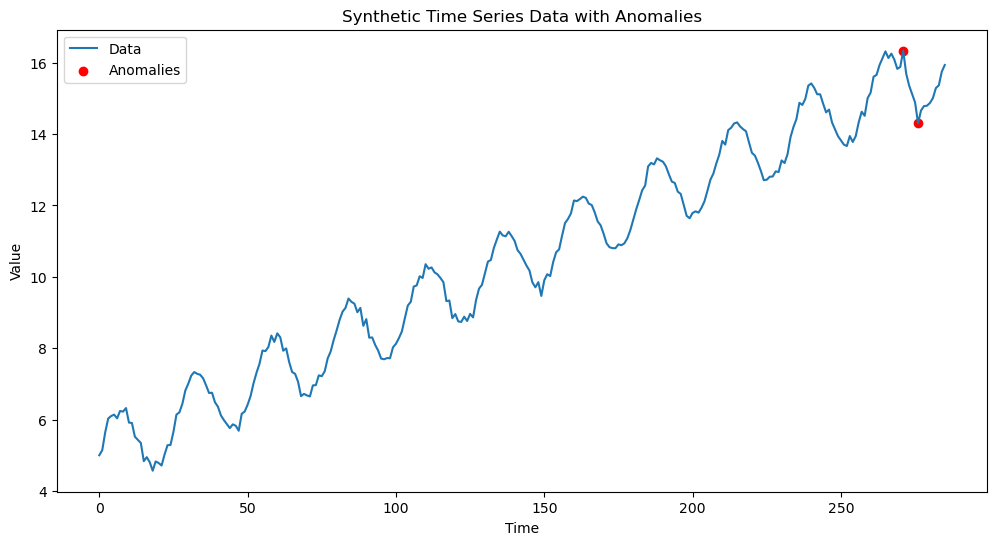

Data saved to ../data/dumb_anomly.csv


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from samay.model import MomentModel
from samay.dataset import MomentDataset
from samay.utils import load_args

repo = "AutonLab/MOMENT-1-large"
config = {
    "task_name": "reconstruction",
}
mmt = MomentModel(config=config, repo=repo)

# prepare the dataset
seasonality = np.sin(np.linspace(0, 22 * np.pi, 286))  # example seasonality
trend = np.linspace(0, 11, 286)  # example trend
residual = np.random.normal(0, 0.1, 286)  # example noise
offset = 5

d = seasonality + trend + residual + offset
labels = [0] * 286  # no anomalies initially
a_start = 260
a_end = 286
idx1 = np.random.randint(a_start, a_end)
idx2 = np.random.randint(a_start, a_end)
# make the 2 indices anomalous
d[idx1] += np.random.uniform(0.5, 1) * np.random.choice([-1, 1])  # add an anomaly
d[idx2] += np.random.uniform(0.5, 1) * np.random.choice([-1, 1])  # add another anomaly
# set the labels for these indices
labels[idx1] = 1  # mark as anomalous
labels[idx2] = 1  # mark as anomalous

# create the data dict
data = {
    "data": d,
    "labels": labels,
}

# draw the data and point out the anomalies
plt.figure(figsize=(12, 6))
plt.plot(data["data"], label="Data")
plt.scatter(
    [idx1, idx2], [data["data"][idx1], data["data"][idx2]], color="red", label="Anomalies"
)
plt.title("Synthetic Time Series Data with Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# create a pandas dataframe from the data and cut off headers
df = pd.DataFrame(data)

# save the dataframe to a csv file
csv_path = "../data/dumb_anomly.csv"

df.to_csv(csv_path, index=False)
print(f"Data saved to {csv_path}")



[ 0.11536691  0.39910352  0.6702527   0.8381546   0.8101016   0.96350837
  0.9251589   0.97172934  0.93232346  0.87024295  0.7509446   0.46875694
  0.00318913 -0.38772017 -0.7193864  -0.9238248  -1.2334055  -1.2657824
 -1.0537757  -0.9348201  -0.68402195 -0.36003095 -0.12184956  0.1439959
  0.20710462  0.34905162]


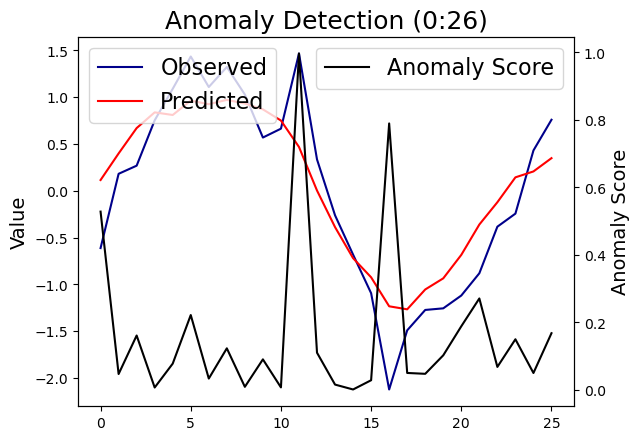

Best F1 Score: 1.0000 at threshold 0.5343
Epoch 0: Train loss: 0.253


/nethome/sli999/anaconda3/envs/torch/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1: Train loss: 0.414
Epoch 2: Train loss: 0.173
Epoch 3: Train loss: 0.282
Epoch 4: Train loss: 0.263
[ 0.1195857   0.40292627  0.6682871   0.83578235  0.80853844  0.9615975
  0.92404765  0.97031367  0.93144333  0.8688031   0.7580084   0.47539514
  0.01029949 -0.38093317 -0.7121319  -0.9168346  -1.2260907  -1.25853
 -1.0494823  -0.9308098  -0.67957425 -0.3558277  -0.11752129  0.14800104
  0.21148385  0.35330153]


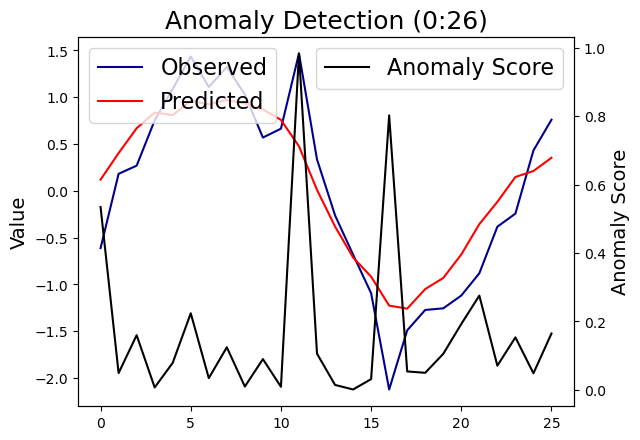

Best F1 Score: 1.0000 at threshold 0.5369


In [2]:

train_dataset = MomentDataset(name="ett", path=csv_path,
                            mode="train", boundaries=[260, 260, 0], task_name='detection', stride=512)
test_dataset = MomentDataset(name="ett", path=csv_path,
                            mode="test", boundaries=[260, 260, 0], task_name='detection', stride=512)

mmt.plot(test_dataset, task_name='detection')
finetuned_model = mmt.finetune(
train_dataset, task_name="detection", mask_ratio=0.1, epoch=5)
mmt.plot(test_dataset, task_name='detection')